In [2]:
from pandas import DataFrame, read_csv, set_option, cut, qcut
from matplotlib.pyplot import figure, show, subplots, savefig
from ds_charts import dummify, plot_line, multiple_line_chart
from  mlxtend.frequent_patterns import apriori, association_rules
set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

sample = 0.005

file_tag = 'set1'
filename = 'ew_data/set1'
target = 'PERSON_INJURY'

dataOriginal: DataFrame = read_csv(f'ew_data/{file_tag}_mv_dummified.csv')
dataOriginal = dataOriginal.sample(frac=sample, replace=True, random_state=1)

## After equal-width

In [10]:
data_treatment = 'equal_width'
data = dataOriginal.drop(['PERSON_ID', 'VEHICLE_ID','UNIQUE_ID', 'COLLISION_ID'], axis=1)
columns = ['COMPLAINT','EMOTIONAL_STATUS','CRASH_MONTH','CRASH_DAY','PERSON_AGE']
data = data[columns]
bins = 3
for col in columns:
    data[col] = cut(data[col], bins= bins)
data = dummify(data, columns)
for col in data.columns:
    if col not in columns:
        data[data[col] == True] = 1
        data[data[col] == False] = 0

data

,"COMPLAINT_(-0.01, 3.333]","COMPLAINT_(3.333, 6.667]","COMPLAINT_(6.667, 10.0]","EMOTIONAL_STATUS_(-0.01, 3.333]","EMOTIONAL_STATUS_(6.667, 10.0]","CRASH_MONTH_(0.989, 4.667]","CRASH_MONTH_(4.667, 8.333]","CRASH_MONTH_(8.333, 12.0]","CRASH_DAY_(0.97, 11.0]","CRASH_DAY_(11.0, 21.0]","CRASH_DAY_(21.0, 31.0]","PERSON_AGE_(0.923, 26.667]","PERSON_AGE_(26.667, 52.333]","PERSON_AGE_(52.333, 78.0]"
29733,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
235,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12172,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5192,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17289,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11274,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
22807,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
16252,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
26503,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Processing 14 combinations | Sampling itemset size 14320
16383 patterns


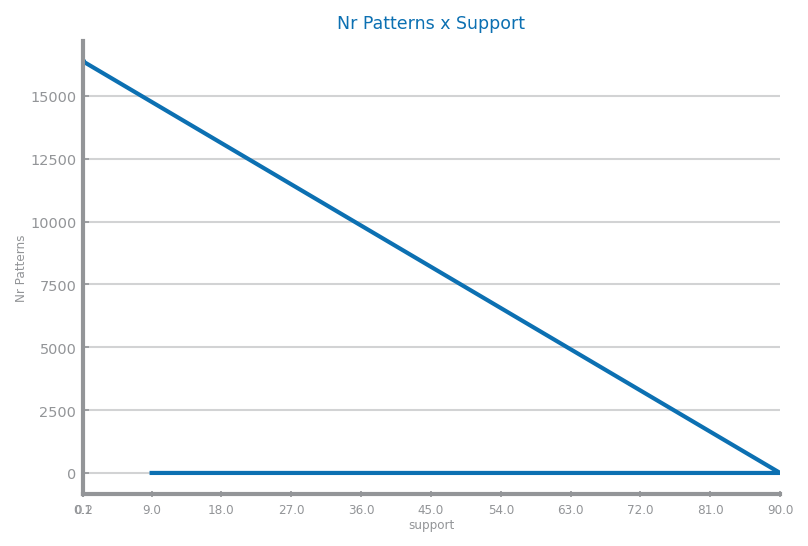

In [11]:
MIN_SUP: float = 0.9
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]

patterns: DataFrame = apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support'] >= sup]
    nr_patterns.append(len(pat))

figure(figsize=(6, 4))
plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_patterns_support.png')
show()

In [12]:
MIN_CONF: float = 0.1
rules = association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 4750202 rules


In [14]:
def plot_top_rules(rules: DataFrame, metric: str, per_metric: str, file_tag: str, data_treatment: str) -> None:
    _, ax = subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_top_{metric}_{per_metric}.png')
    show()

def analyse_per_metric(rules: DataFrame, metric: str, metric_values: list, file_tag: str, data_treatment: str) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = subplots(1, 2, figsize=(10, 5), squeeze=False)
    multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_{metric}_avg_lift_avg_confidence.png')
    show()

    plot_top_rules(top_conf, 'confidence', metric, file_tag, data_treatment)
    plot_top_rules(top_lift, 'lift', metric, file_tag, data_treatment)

    return nr_rules

Analyse per support...


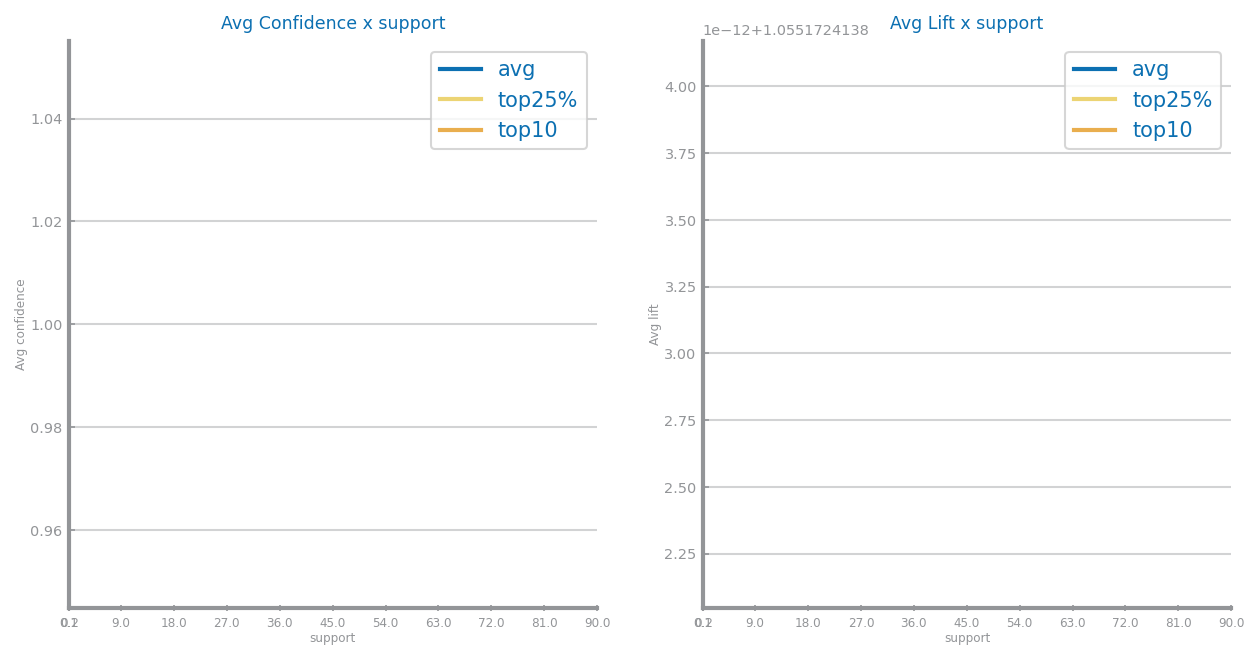

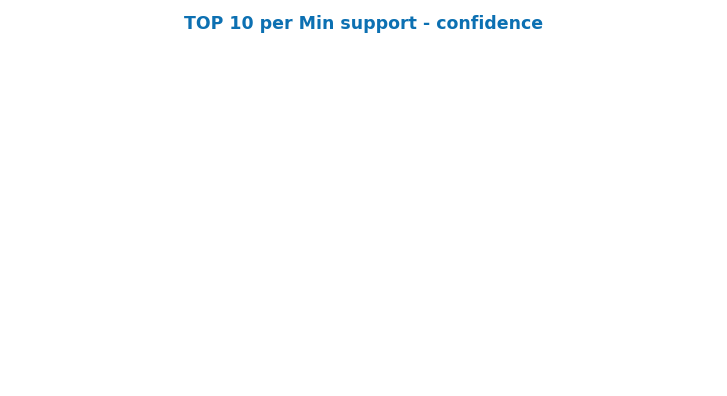

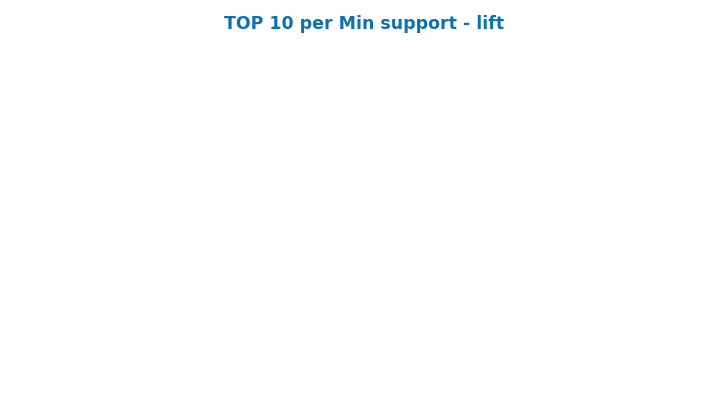

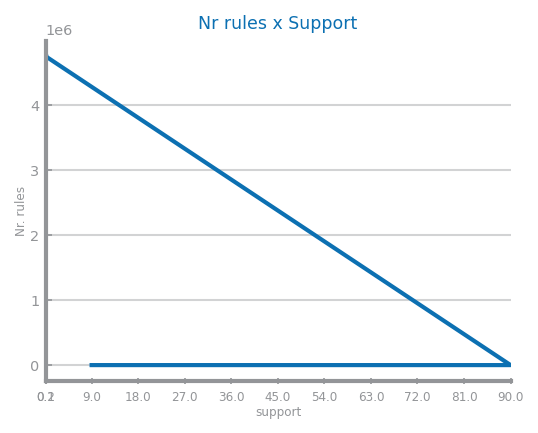

In [15]:
nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup, file_tag, data_treatment)
plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)
savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_rules_support.png')

Analyse per confidence...


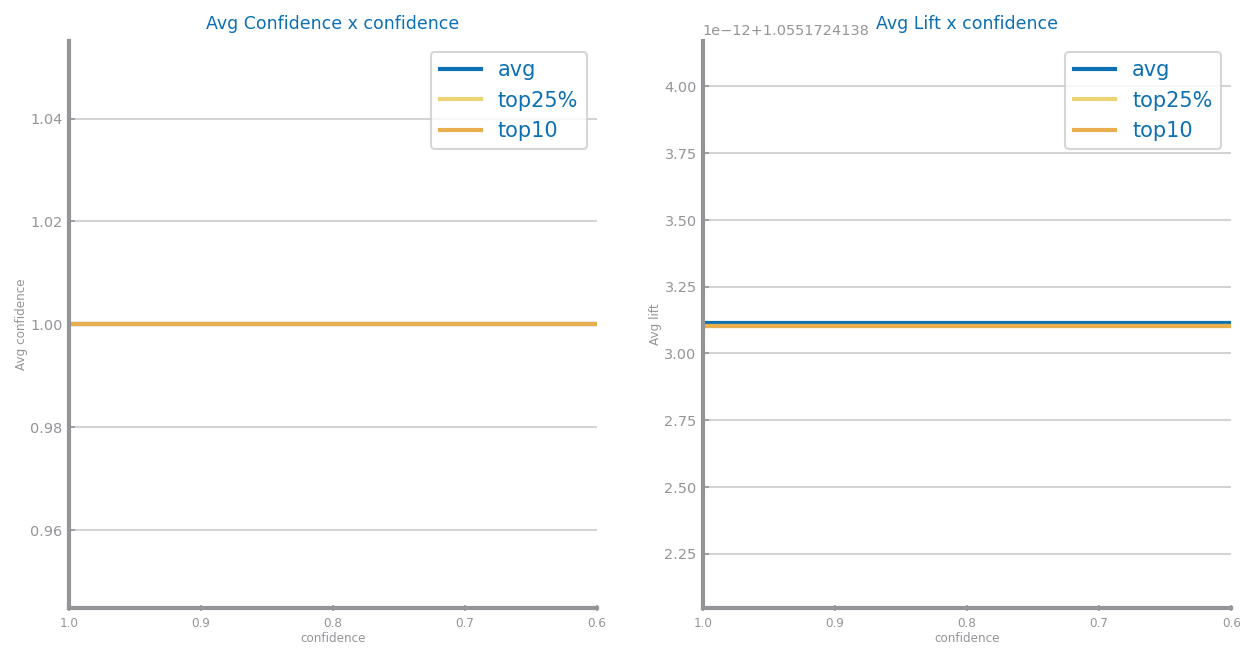

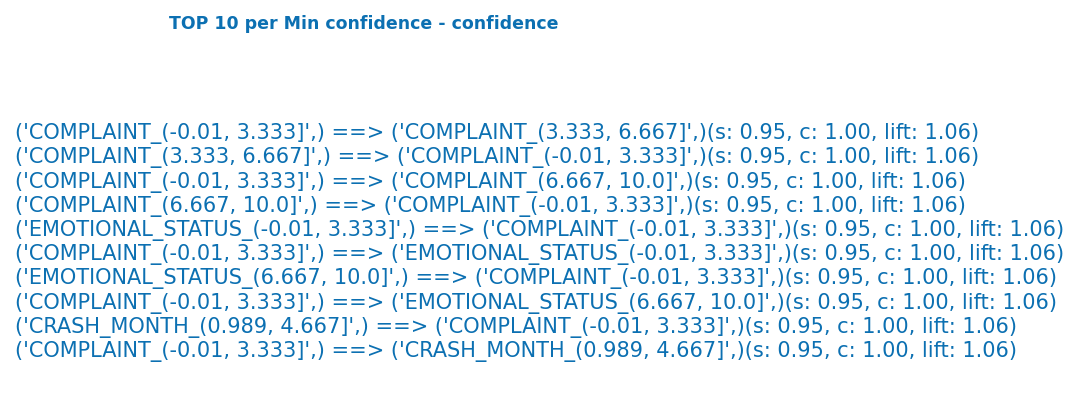

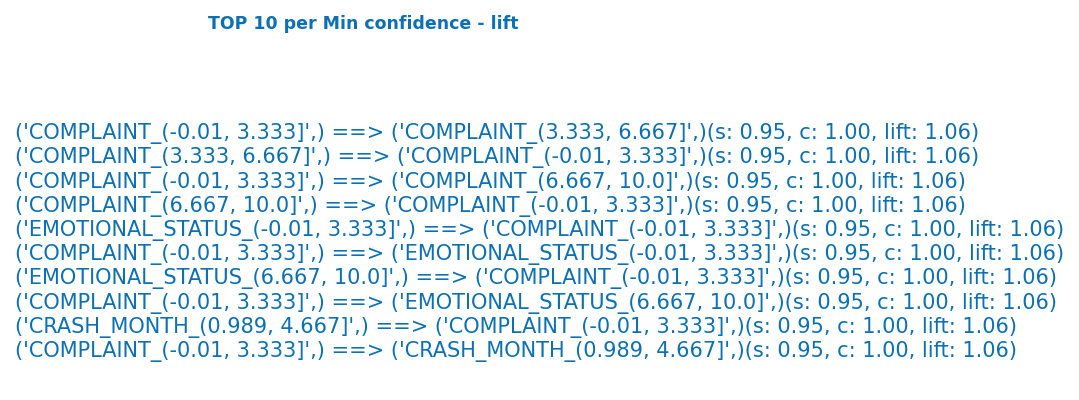

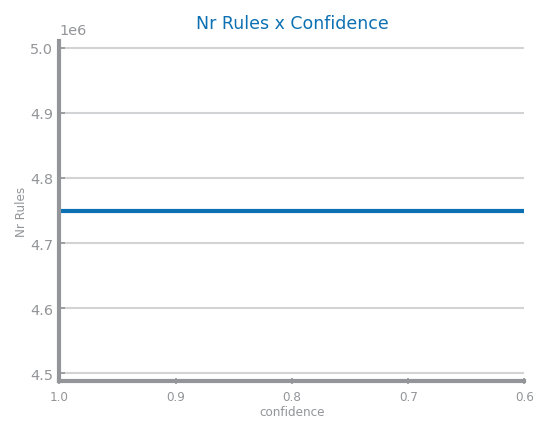

In [16]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf, file_tag, data_treatment)
plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)
savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_rules_confidence.png')